# Heart Failure Prediction

## Importing Libraries

Importing neccessary libraries

In [705]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import time
#import sys
%matplotlib inline
warnings.filterwarnings('ignore')

Importing and intialising classification models

In [706]:
from sklearn.metrics import accuracy_score,classification_report
classifier=[]
imported_as=[]

#MultiLayerPerceptron
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier()
classifier.append('Multi Layer Perceptron')
imported_as.append('mlp')

#Bagging
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
classifier.append('Bagging')
imported_as.append('bc')

#GBC
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
classifier.append('Gradient Boosting')
imported_as.append('gbc')

#ADA
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
classifier.append('Ada Boost')
imported_as.append('ada')

#XGB
import xgboost as xgb
from xgboost import XGBClassifier
xgb = XGBClassifier() 
classifier.append('XG Boost')
imported_as.append('xgb')

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
classifier.append('Logistic Regression')
imported_as.append('lr')

#RFC
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
classifier.append('Random Forest')
imported_as.append('rfc')

#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
classifier.append('k Nearest Neighbours')
imported_as.append('knn')

#SVM
from sklearn.svm import SVC
svc = SVC()
classifier.append('Support Vector Machine')
imported_as.append('svc')

#Grid
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100, 1000,2000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
classifier.append('SVM tuning grid')
imported_as.append('grid')

#STcaking
from sklearn.ensemble import StackingClassifier
estimators=[('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
            ('svr',SVC(random_state=42))]
stc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
classifier.append('Stacked (RFR & SVM)')
imported_as.append('stc')

classifiers = pd.DataFrame({'Classifier':classifier,'Imported as':imported_as})
print('All Models Imported\nModels stored in dataframe called classifiers')

All Models Imported
Models stored in dataframe called classifiers


Creating a Class _Modelling_ to fit and selet the best classifier

In [707]:
class Modelling:
    def __init__(self, X_train, Y_train, X_test, Y_test, models):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.models = models
    
    def fit(self):
        model_acc = []
        model_time= []
        for i in self.models:
            start=time.time()
            if i == 'knn':
                accuracy = []
                for j in range(1,200):    
                    kn = KNeighborsClassifier(n_neighbors=j)
                    kn.fit(self.X_train,self.Y_train)
                    predK = kn.predict(self.X_test)
                    accuracy.append([accuracy_score(self.Y_test,predK),j])
                temp = accuracy[0]
                for m in accuracy:
                    if temp[0] < m[0]:
                        temp=m
                i = KNeighborsClassifier(n_neighbors=temp[1])
            i.fit(self.X_train,self.Y_train)
            model_acc.append(accuracy_score(self.Y_test,i.predict(self.X_test)))
            stop=time.time()
            model_time.append((stop-start))
            print(i,'has been fit')
        self.models_output = pd.DataFrame({'Models':self.models,'Accuracy':model_acc,'Runtime (s)':model_time})
        
    def results(self):
        models=self.models_output
        models = models.sort_values(by=['Accuracy','Runtime (s)'],ascending=[False,True]).reset_index().drop('index',axis=1)
        self.best = models['Models'][0]
        models['Models']=models['Models'].astype(str).str.split("(", n = 2, expand = True)[0]
        models['Accuracy']=models['Accuracy'].round(5)*100
        self.models_output_cleaned=models
        return(models)
        
    def best_model(self,type):
        if type=='model':
            return(self.best)
        elif type=='name':
            return(self.models_output_cleaned['Models'][0])
    
    def best_model_accuracy(self):
        return(self.models_output_cleaned['Accuracy'][0])
    
    def best_model_runtime(self):
        return(round(self.models_output_cleaned['Runtime (s)'][0],3))
    
    def best_model_predict(self,X_test):
        return(self.best.predict(X_test))
    
    def best_model_clmatrix(self):
        return(classification_report(self.Y_test,self.best.predict(self.X_test)))

## Importing data

In [708]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [709]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# EDA

In [710]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


<AxesSubplot:>

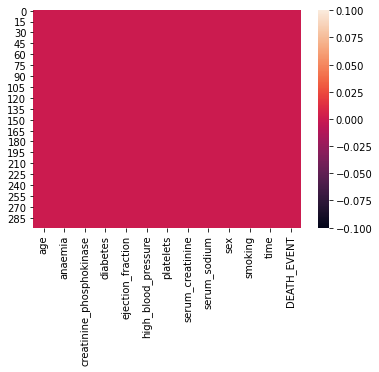

In [711]:
sns.heatmap(data.isnull())

This shows that we have no data missing

<AxesSubplot:>

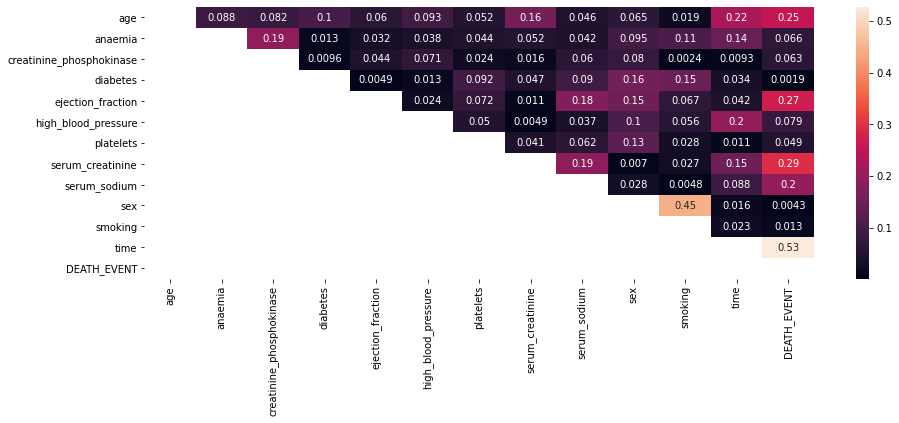

In [712]:
cor_matrix = data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
plt.figure(figsize=(15,5))
sns.heatmap(upper_tri,annot=True)

In [713]:
data.groupby('DEATH_EVENT').median()[['age','creatinine_phosphokinase','platelets','serum_sodium']]

,age,creatinine_phosphokinase,platelets,serum_sodium
DEATH_EVENT,,,,
0,60.0,245.0,263000.0,137.0
1,65.0,259.0,258500.0,135.5


Since no 2 columns have a correlation coef greater than 0.90, no column is dropped here

Relation between death and  non boolean parameters

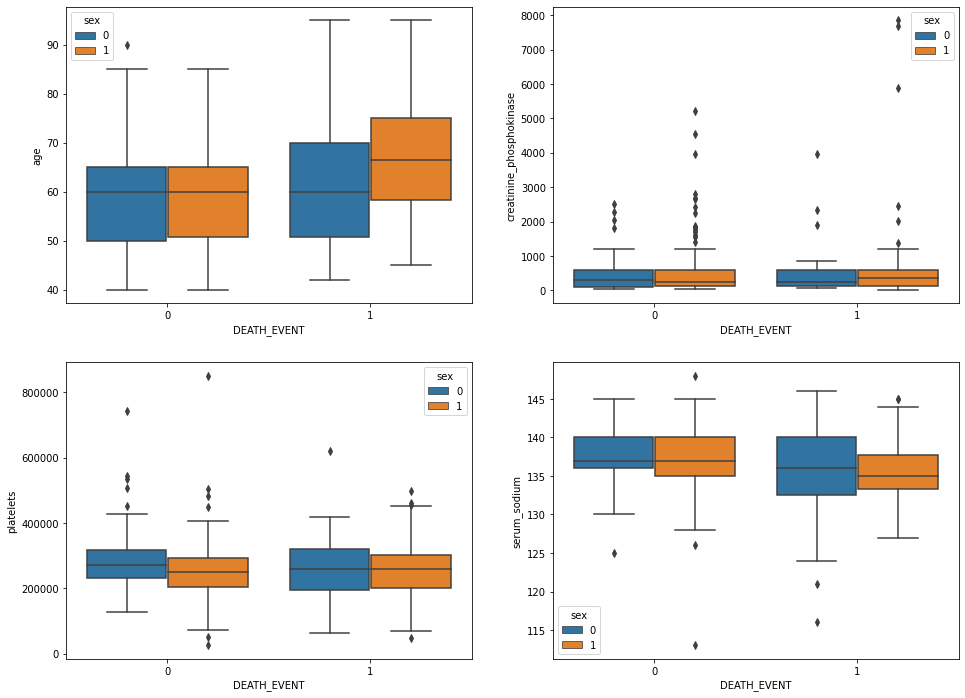

In [714]:
m=1
cols=['age','creatinine_phosphokinase','platelets','serum_sodium']
plt.figure(figsize=(16,12))
for i in cols:
    plt.subplot(2,2,m)
    m+=1
    sns.boxplot(x='DEATH_EVENT',y=i,hue='sex',data=data)


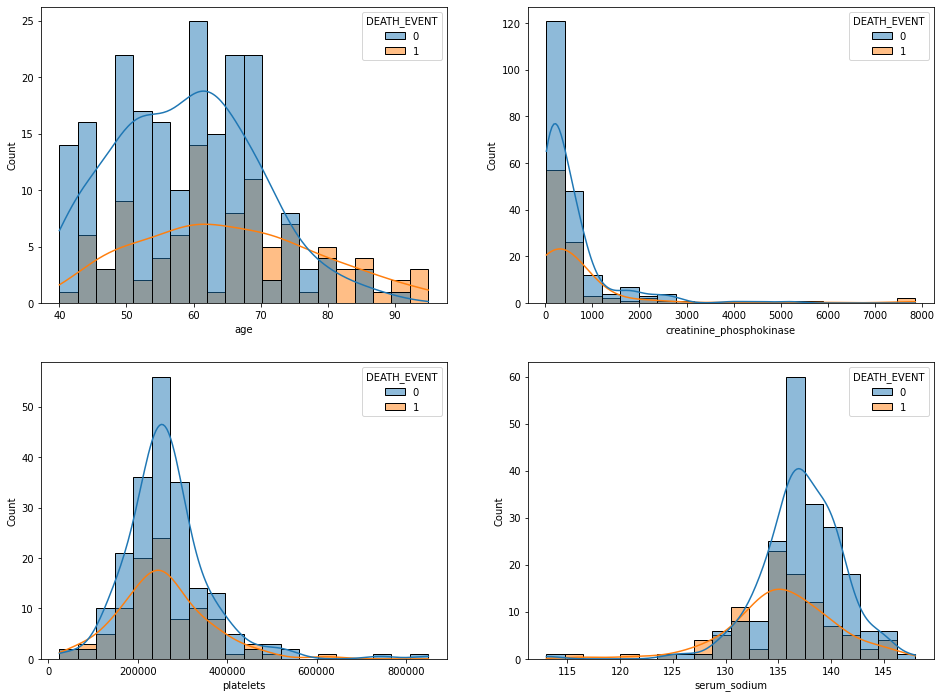

In [715]:
m=1
cols=['age','creatinine_phosphokinase','platelets','serum_sodium']
plt.figure(figsize=(16,12))
for i in cols:
    plt.subplot(2,2,m)
    m+=1
    sns.histplot(hue='DEATH_EVENT',x=i,data=data,kde=True,bins=20)

Relation between death and boolean parameters

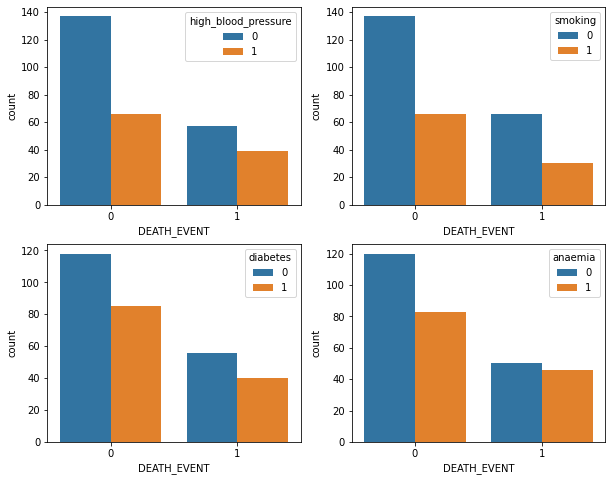

In [716]:
cols=['high_blood_pressure','smoking','diabetes','anaemia']
plt.figure(figsize=(10,8),num=1)
m=1
for i in cols:
    plt.subplot(2,2,m)
    sns.countplot(x='DEATH_EVENT',hue=i,data=data)
    m+=1

## Data Scaling¶

In [717]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[['age','creatinine_phosphokinase','platelets','serum_sodium']] = scaler.fit_transform(data[['age','creatinine_phosphokinase','platelets','serum_sodium']])

## Data Split

In [718]:
X = data.drop('DEATH_EVENT',axis=1)
Y = data['DEATH_EVENT']

## Test Train Split

In [719]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=100)

## Model Evaluation

In [720]:
display(classifiers)

,Classifier,Imported as
0,Multi Layer Perceptron,mlp
1,Bagging,bc
2,Gradient Boosting,gbc
3,Ada Boost,ada
4,XG Boost,xgb
5,Logistic Regression,lr
6,Random Forest,rfc
7,k Nearest Neighbours,knn
8,Support Vector Machine,svc
9,SVM tuning grid,grid


In [721]:
models_to_test = [stc,bc,gbc,ada,xgb,rfc,knn,svc,mlp]

In [722]:
classification = Modelling(X_train,Y_train,X_test,Y_test,models_to_test)
classification.fit()

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr', SVC(random_state=42))],
                   final_estimator=LogisticRegression()) has been fit
BaggingClassifier() has been fit
GradientBoostingClassifier() has been fit
AdaBoostClassifier() has been fit
[13:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step

In [723]:
classification.results()

,Models,Accuracy,Runtime (s)
0,KNeighborsClassifier,85.556,0.012965
1,GradientBoostingClassifier,85.556,0.105716
2,StackingClassifier,85.556,0.241352
3,RandomForestClassifier,85.556,0.281250
4,SVC,84.444,0.009972
5,XGBClassifier,84.444,0.117682
6,AdaBoostClassifier,80.000,0.110706
7,MLPClassifier,80.000,0.181537
8,BaggingClassifier,78.889,0.032913


In [724]:
print('BestModel is:',  classification.best_model(type='name'))
print('Accuracy of model:',classification.best_model_accuracy())
print('Training Runtime in seconds',classification.best_model_runtime())
print('Classification Matrix:\n')
print(classification.best_model_clmatrix())

BestModel is: KNeighborsClassifier
Accuracy of model: 85.556
Training Runtime in seconds 0.013
Classification Matrix:

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        59
           1       0.88      0.68      0.76        31

    accuracy                           0.86        90
   macro avg       0.86      0.81      0.83        90
weighted avg       0.86      0.86      0.85        90



In [726]:
X.shape

(299, 12)